## Exploiting Intermediate Value Leakage in Dilithium : A Template-Based Approach
-------

### **Data sets Overview**
--------------
In this notebook, we will present the data sets.
All trace sets are ets files (eShard trace set) based on the HDF5 file format

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from IPython.display import display
import scared
import estraces
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [13]:
plt.rcParams["figure.figsize"] = (20,2)
vhex = np.vectorize(hex)

In [14]:
from ipywidgets import interact

### Trace set Acquisition
-----

The power traces have been generated on a ChipWhisperer-STM32F303 target executing the PQClean library default implementation. 

- A fixed secret key `sk` is used for all the data sets (cf value in dilithium2skpk_decompose)
- We target the first call of the decompose function on the first polynomial `w[0]`
- The decompose function has been adapted to trigger the acquisition

```
void PQCLEAN_DILITHIUM2_CLEAN_poly_decompose(poly *a1, poly *a0, const poly *a) {
    unsigned int i;
    DBENCH_START();

    for (i = 0; i < N; ++i) {
        trigger_high();
        a1->coeffs[i] = PQCLEAN_DILITHIUM2_CLEAN_decompose(&a0->coeffs[i], a->coeffs[i]);
        trigger_low();
    }
    DBENCH_STOP(*tround);
}
```

In [20]:
ths_building = scared.traces.read_ths_from_ets_file('./dataset/profiling_hw_w0_v4.zip.ets')
ths_building

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ./dataset/profiling_hw_w0_v4.zip.ets with 749017 traces.
msg..............: uint8
w0...............: uint8
w0_hw............: uint8

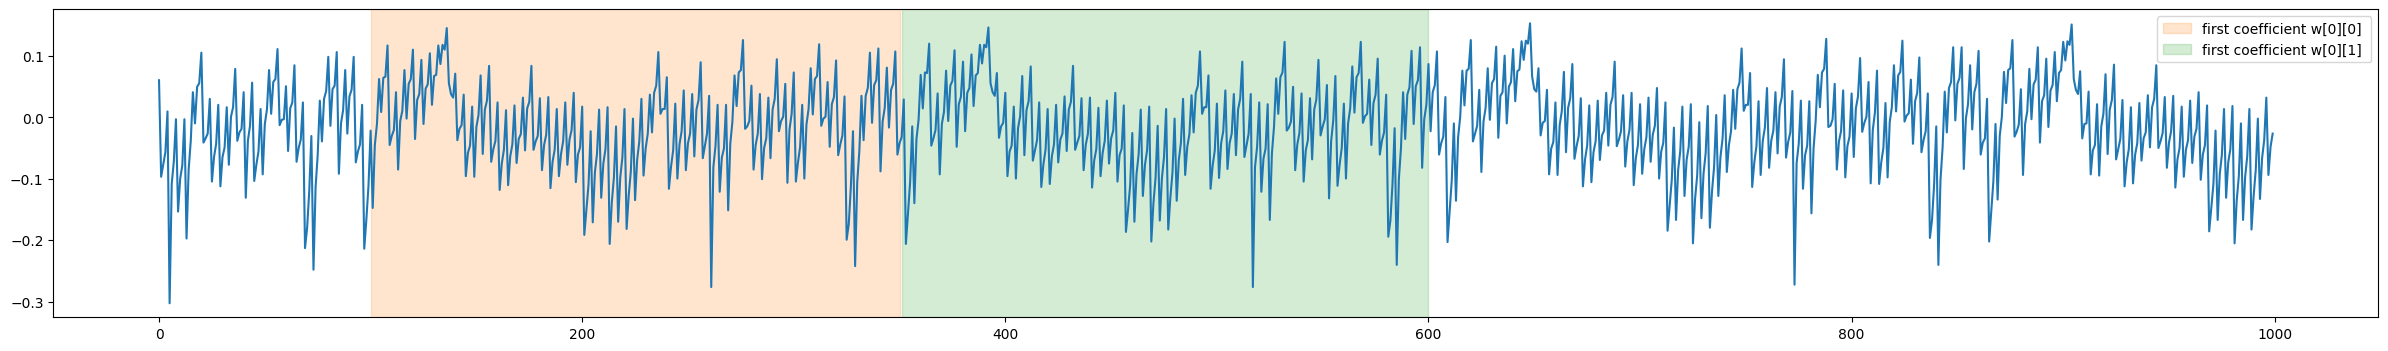

In [29]:
fg, ax = plt.subplots(figsize=(30,4))
ax.axvspan(xmin=100, xmax=350, alpha=0.2, color="C1", label="first coefficient w[0][0] ")
ax.axvspan(xmin=351, xmax=600, alpha=0.2, color="C2", label="first coefficient w[0][1] ")
ax.plot(ths_building.samples[0].T)
plt.legend()
plt.show()

### Data sets:
-------

- Building data set:
    - `profiling_hw_w0_v4_synchronized_v2.zip.ets` contains the traces and random metadatas for the profiling phase

 
- Matching data sets:
    - `matching_fixed_v3.zip.ets` contains the traces and fixed metadatas for the matching phase
    - `Dilithium2_w{i}_to_0.ets` contains the traces and fixed metadatas for testing the modularity of the template
      

### Metadata:
-------
Each power trace is associated to the following metadata:
- `w0` : contains the 4 bytes of the coefficient
- `w0_hw` : contains the Hamming value of the `w0`

In [31]:
ths_building.w0

array([[  0,   0,   8, 136],
       [255, 255,   1, 129],
       [255, 255, 255, 185],
       ...,
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]], dtype=uint8)

In [40]:
ths_building.w0_hw == scared.models.HammingWeight(nb_words=4, expected_dtype='uint8')(ths_building.w0)

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

### Details of the building data set metadata
-------------

Considering the hamming weigth model of each of the 4 bytes of `w0`, the building data set contains enough representative in each class

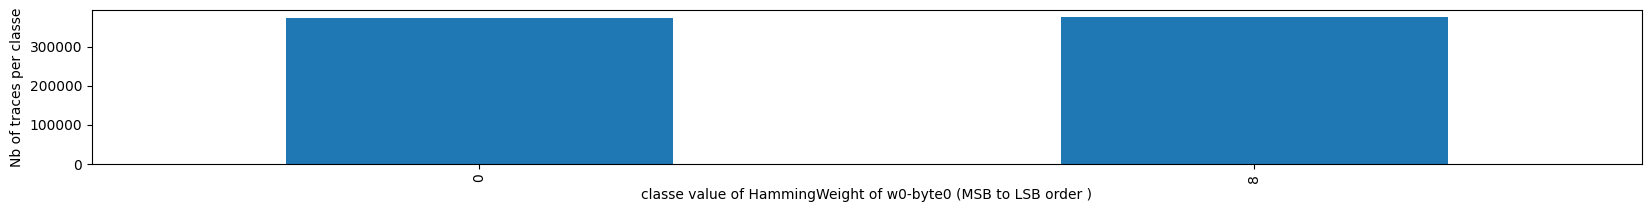

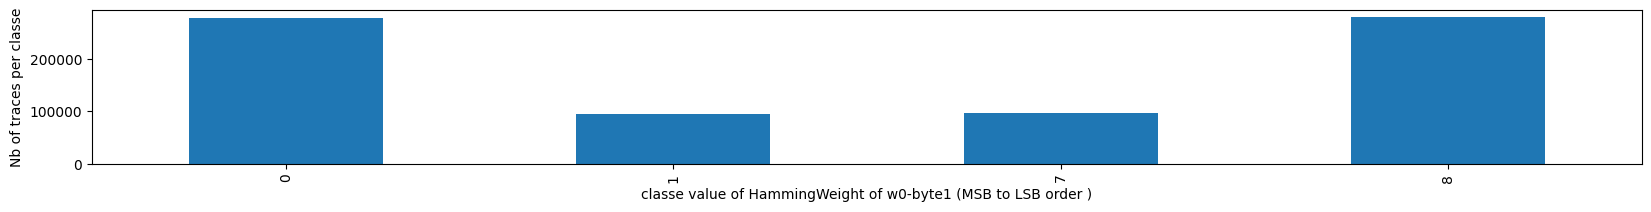

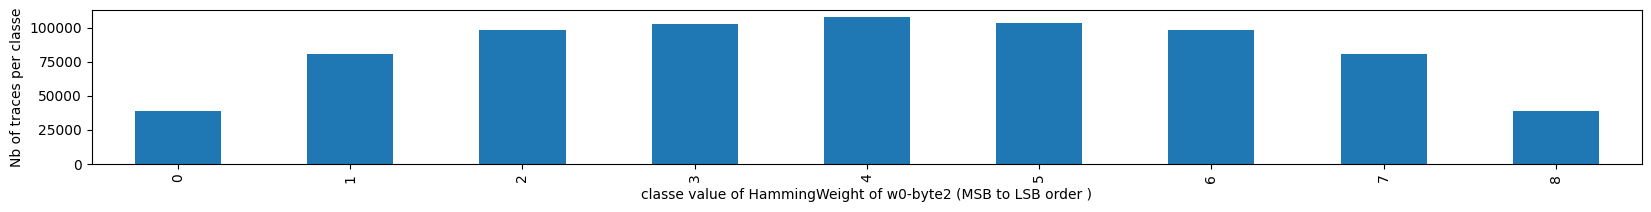

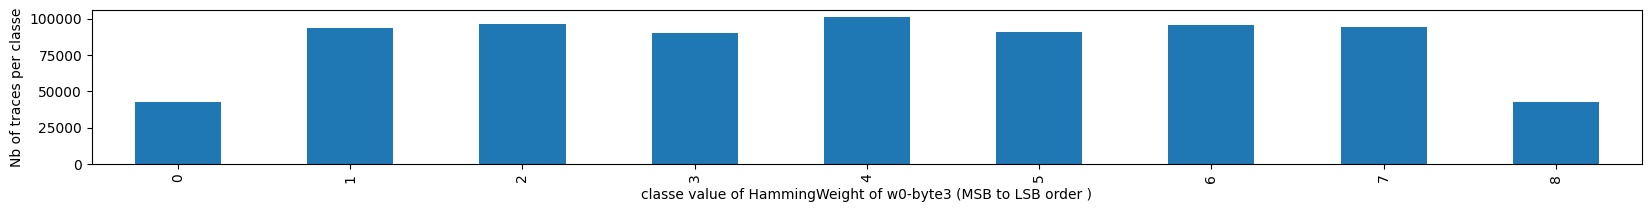

In [6]:
for i in range(4):
    df = pd.DataFrame.from_dict(Counter((scared.models.HammingWeight()(ths_building.w0[:,i]))), orient='index')
    plot = df.sort_index().plot.bar(xlabel=f'classe value of HammingWeight of w0-byte{i} (MSB to LSB order )', ylabel='Nb of traces per classe', legend=False)
    fig = plot.get_figure()

### Details of the matching data sets
-------------
The matching data is composed of 1000 traces with a fixed input message

In [7]:
ths_matching = scared.traces.read_ths_from_ets_file('./dataset/matching_fixed_v3.zip.ets')

In [8]:
ths_matching.msg

array([[224, 158, 225, ..., 223,  82, 229],
       [224, 158, 225, ..., 223,  82, 229],
       [224, 158, 225, ..., 223,  82, 229],
       ...,
       [224, 158, 225, ..., 223,  82, 229],
       [224, 158, 225, ..., 223,  82, 229],
       [224, 158, 225, ..., 223,  82, 229]], dtype=uint8)

##### Matching and Building traces samples
-------------
Both data sets are correctly synchronized

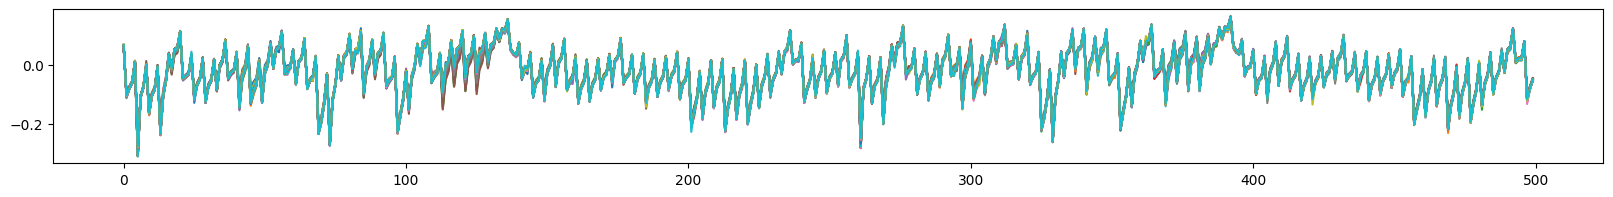

In [11]:
plt.plot(ths_building.samples[0:20].T[:500])
plt.plot(ths_matching.samples[0:20].T[:500])
plt.show() 

In order to test the template modularity, the matching data sets contains the first 94 coefficients of `w[0]` where one coefficient (at position w0_index) is equal to `0`

In [46]:
ths_matching = scared.traces.read_ths_from_ets_file('./dataset/matching/Dilithium2_w3_to_0.ets')

In [47]:
ths_matching.metadatas

dict_keys(['msg', 'w0', 'w0_index'])-ETS format reader of file ./dataset/matching/Dilithium2_w3_to_0.ets with 10 traces.

In [48]:
ths_matching.w0_index

array([[3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3]])

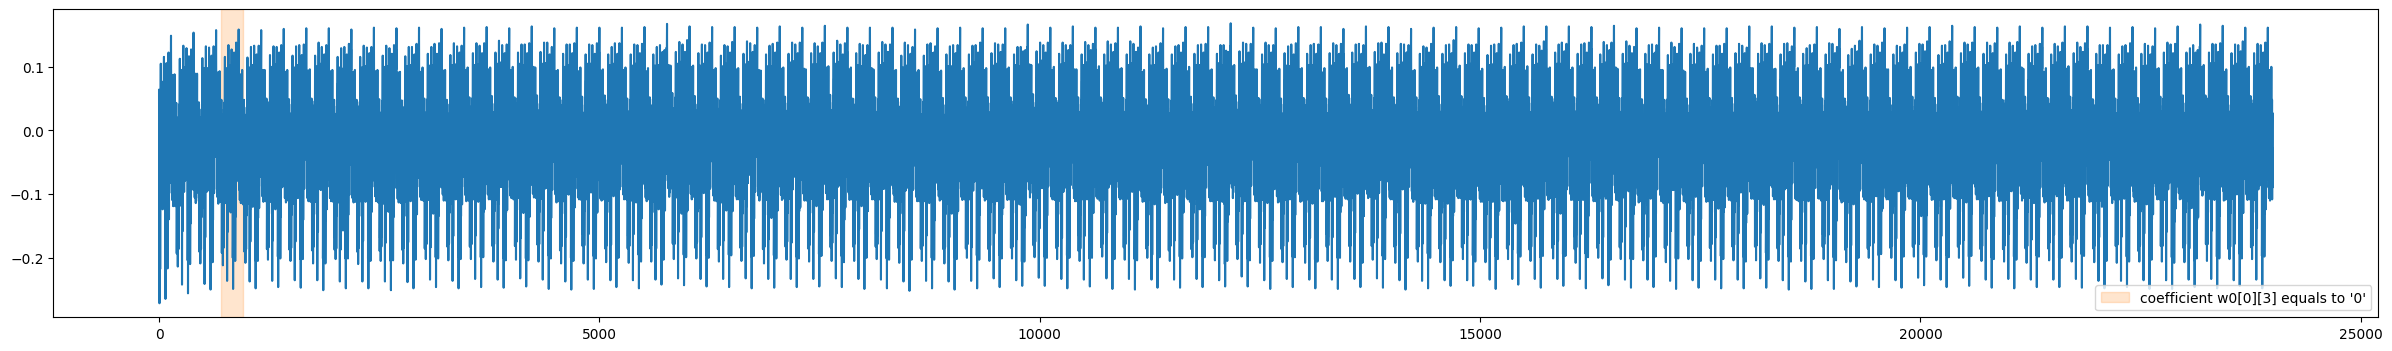

In [55]:
fg, ax = plt.subplots(figsize=(30,4))
ax.axvspan(xmin=700, xmax=950, alpha=0.2, color="C1", label="coefficient w0[0][3] equals to '0'")
ax.plot(ths_matching.samples[0].T)
plt.legend()
plt.show()